In [1]:
import pandas as pd
from pandas import Series, DataFrame
import numpy as np
from scipy.stats import mode
import csv
import matplotlib.dates
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns
from datetime import *

%matplotlib inline

In [3]:
# 导入数据
df = pd.read_csv('train_20171215.txt', sep='\t')

print(df.info())
print(df.describe())
print(df.head(10))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4773 entries, 0 to 4772
Data columns (total 4 columns):
date           4773 non-null int64
day_of_week    4773 non-null int64
brand          4773 non-null int64
cnt            4773 non-null int64
dtypes: int64(4)
memory usage: 149.2 KB
None
              date  day_of_week        brand          cnt
count  4773.000000  4773.000000  4773.000000  4773.000000
mean    524.399749     3.512047     2.990153   380.567358
std     297.546919     1.738846     1.417509   252.720918
min       1.000000     1.000000     1.000000    12.000000
25%     271.000000     2.000000     2.000000   221.000000
50%     529.000000     3.000000     3.000000   351.000000
75%     781.000000     5.000000     4.000000   496.000000
max    1032.000000     7.000000     5.000000  2102.000000
   date  day_of_week  brand   cnt
0     1            3      1    20
1     1            3      5    48
2     2            4      1    16
3     2            4      3    20
4     3          

D:\win10-Application\Anaconda\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  after removing the cwd from sys.path.


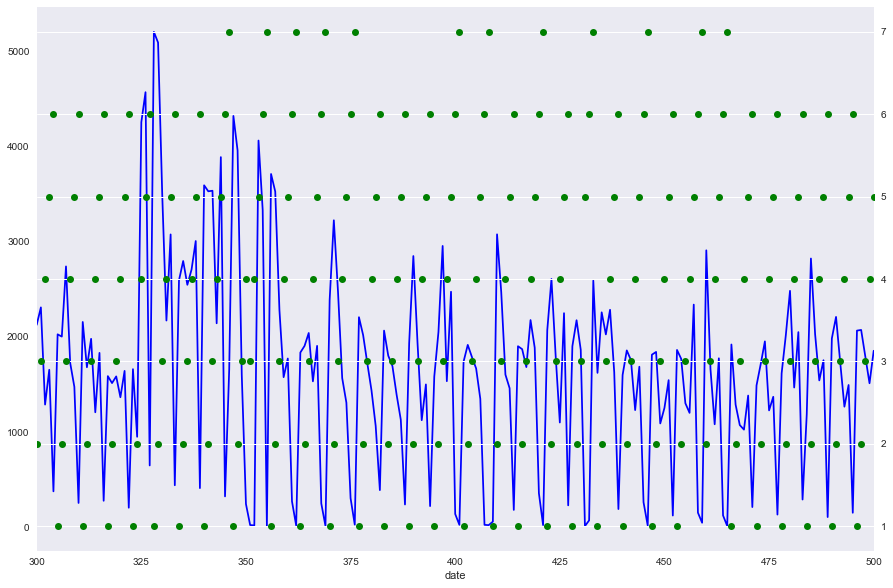

In [4]:
# 日期与上排量曲线
dataDf = pd.pivot_table(df,index=["date"], values=["cnt","day_of_week"], aggfunc={"cnt":np.sum, "day_of_week": np.max})
fig, ax = plt.subplots(figsize=(15,10))
dataDf.ix[300:500, 'cnt'].plot(ax=ax, style='b-')
dataDf.ix[300:500, 'day_of_week'].plot(ax=ax, style='go', secondary_y=True)

In [5]:
# 标记周数
def tickWeek(df, start):
    preVal = df[:-1]['day_of_week'].values
    preVal = np.insert(preVal, 0, preVal[0]-1)
    df['new_week'] = (preVal >= df.day_of_week)
    weekList = list()
    week = start
    for item in df['new_week']:
        week += (1 if item else 0)
        weekList.append(week)
    df['week'] = weekList
    return df

In [6]:
# 标记周数+修正日期
dataDf = pd.pivot_table(df,index=["date"], values=["cnt","day_of_week"], aggfunc={"cnt":np.sum, "day_of_week": np.max})
dataDf = tickWeek(dataDf, 0)
dataDf['day'] = dataDf['week']*7 + dataDf['day_of_week']
print(dataDf.head(10))

       cnt  day_of_week  new_week  week  day
date                                        
1       68            3     False     0    3
2       36            4     False     0    4
3     5565            5     False     0    5
4     4966            6     False     0    6
5     3346            7     False     0    7
6     3396            1      True     1    8
7     4146            2     False     1    9
8     3096            3     False     1   10
9     2713            4     False     1   11
10    2409            5     False     1   12


'\n1.大致规律是每一周的周六周日是谷值，通常在500以下\n2.周日的数据缺失比较多\n'

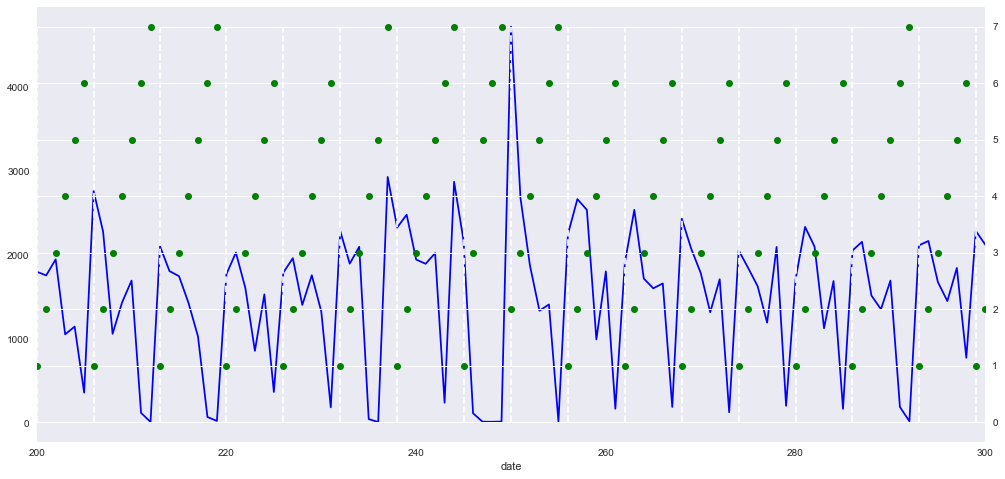

In [7]:
# 日期与上排量曲线
drawDf = dataDf.loc[200:300]
fig, ax = plt.subplots(figsize=(17,8))
drawDf['cnt'].plot(ax=ax, style='b-')
drawDf['day_of_week'].plot(ax=ax, style='go', secondary_y=True)
plt.vlines(x=drawDf[drawDf.new_week].index,ymin=0,ymax=7,colors='w',linestyles='dashed')
'''
1.大致规律是每一周的周六周日是谷值，通常在500以下
2.周日的数据缺失比较多
'''

In [8]:
# 查看周日上牌量情况
print(dataDf[dataDf.day_of_week==7])
'''
周日明显有1000以上跟100以下两批数据，且100以下较多
可以探究下出现1000以上的周的上牌量情况
'''

       cnt  day_of_week  new_week  week   day
date                                         
5     3346            7     False     0     7
18      22            7     False     2    21
31      23            7     False     4    35
40    2936            7     False     6    49
59      41            7     False     9    70
78      22            7     False    12    91
85    1929            7     False    13    98
98      36            7     False    15   112
105   1626            7     False    16   119
116     23            7     False    18   133
135     14            7     False    21   154
142   1309            7     False    22   161
147     26            7     False    23   168
154     36            7     False    24   175
167     14            7     False    26   189
174     23            7     False    27   196
181     14            7     False    28   203
212     14            7     False    33   238
219     26            7     False    34   245
237   2933            7     False 

'\n周日明显有1000以上跟100以下两批数据，且100以下较多\n可以探究下出现1000以上的周的上牌量情况\n'

'\n1.周日高的时候，当周一般会有其他时间出现明显的谷值，谷值情况与其他周相似\n2.结合上个ceil的输出，猜测周日高值的出现会不会与假期调休有关\n'

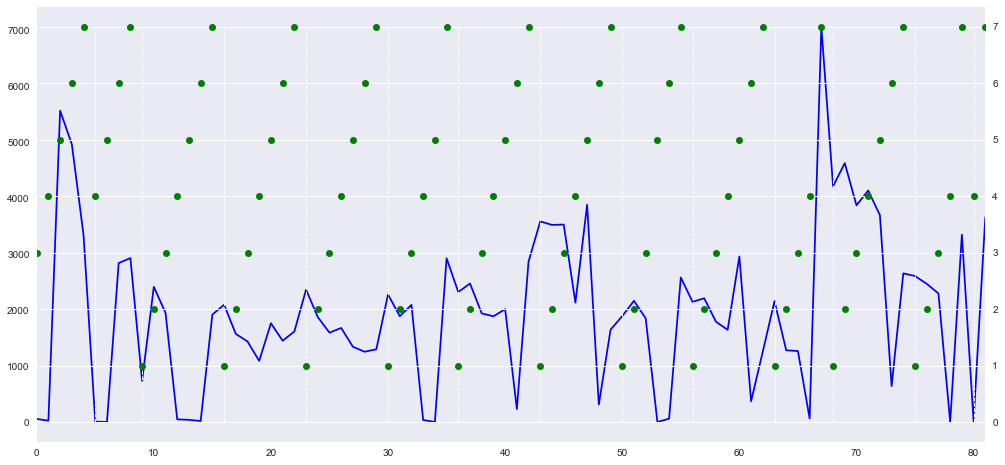

In [9]:
unusualWeek = dataDf[(dataDf.day_of_week==7)&(dataDf.cnt>1000)]['week'].values
testDf = dataDf[dataDf.week.isin(unusualWeek)]
testDf.reset_index(inplace=True)
fig, ax = plt.subplots(figsize=(17,8))
testDf['cnt'].plot(ax=ax, style='b-')
testDf['day_of_week'].plot(ax=ax, style='go', secondary_y=True)
plt.vlines(x=testDf[testDf.new_week].index,ymin=0,ymax=7,colors='w',linestyles='dashed', linewidth=1)
'''
1.周日高的时候，当周一般会有其他时间出现明显的谷值，谷值情况与其他周相似
2.结合上个ceil的输出，猜测周日高值的出现会不会与假期调休有关
'''

In [10]:
# 给数据添加日期字段
def addGuessDate(df, startYear, startMonth, startDay):
    startDate = date(startYear, startMonth, startDay)
    df['guess_date'] = df['day'].map(lambda x: startDate + timedelta(days=x))
    df['guess_date'] = pd.to_datetime(df['guess_date'])
    return df

In [11]:
# 尝试给数据加日期
dataDf = addGuessDate(dataDf,2012,12,30)
print(dataDf[dataDf.week.isin(unusualWeek)])
'''
与异常周的时间相比对，发现明显异常的周，其猜测日期基本在节假日附近
'''

       cnt  day_of_week  new_week  week   day guess_date
date                                                    
1       68            3     False     0     3 2013-01-02
2       36            4     False     0     4 2013-01-03
3     5565            5     False     0     5 2013-01-04
4     4966            6     False     0     6 2013-01-05
5     3346            7     False     0     7 2013-01-06
37      19            4      True     6    46 2013-02-14
38      13            5     False     6    47 2013-02-15
39    2847            6     False     6    48 2013-02-16
40    2936            7     False     6    49 2013-02-17
79     744            1      True    13    92 2013-04-01
80    2424            2     False    13    93 2013-04-02
81    1959            3     False    13    94 2013-04-03
82      60            4     False    13    95 2013-04-04
83      51            5     False    13    96 2013-04-05
84      30            6     False    13    97 2013-04-06
85    1929            7     Fal

'\n与异常周的时间相比对，发现明显异常的周，其猜测日期基本在节假日附近\n'

In [12]:
# 取春节附近数据比对
print(dataDf[dataDf.week.isin([5,6,56,57,111,112,160,161,162])])
'''
连续缺失日期正好位于每年春节期间，基本能确认猜测
'''

       cnt  day_of_week  new_week  week   day guess_date
date                                                    
32    4094            1      True     5    36 2013-02-04
33    4059            2     False     5    37 2013-02-05
34    3741            3     False     5    38 2013-02-06
35    2567            4     False     5    39 2013-02-07
36     761            5     False     5    40 2013-02-08
37      19            4      True     6    46 2013-02-14
38      13            5     False     6    47 2013-02-15
39    2847            6     False     6    48 2013-02-16
40    2936            7     False     6    49 2013-02-17
347   4320            1      True    56   393 2014-01-27
348   3957            2     False    56   394 2014-01-28
349   1598            3     False    56   395 2014-01-29
350    244            4     False    56   396 2014-01-30
351     23            3      True    57   402 2014-02-05
352     19            4     False    57   403 2014-02-06
353   4061            5     Fal

'\n连续缺失日期正好位于每年春节期间，基本能确认猜测\n'

In [13]:
# 提取出现连续n天数据缺失的周数
def hasContMissDate(df, n, dateColName='guess_date'):
    preDate = df[:-1][dateColName].values
    preDate = np.insert(preDate, 0, preDate[0])
    targetWeekList = df[df[dateColName]-preDate>=timedelta(days=n)]['week'].values
    return targetWeekList

In [14]:
# 查看什么情况会出现连续日期缺失
missWeeks = hasContMissDate(dataDf, 4)
print("连续缺失的周：", missWeeks)
missWeeks = np.unique([missWeeks, missWeeks-1])
print(dataDf[dataDf.week.isin(missWeeks)])
'''
可以用连续缺失的周去对齐真实日期
'''

连续缺失的周： [  6  57  92 112 162]
       cnt  day_of_week  new_week  week   day guess_date
date                                                    
32    4094            1      True     5    36 2013-02-04
33    4059            2     False     5    37 2013-02-05
34    3741            3     False     5    38 2013-02-06
35    2567            4     False     5    39 2013-02-07
36     761            5     False     5    40 2013-02-08
37      19            4      True     6    46 2013-02-14
38      13            5     False     6    47 2013-02-15
39    2847            6     False     6    48 2013-02-16
40    2936            7     False     6    49 2013-02-17
347   4320            1      True    56   393 2014-01-27
348   3957            2     False    56   394 2014-01-28
349   1598            3     False    56   395 2014-01-29
350    244            4     False    56   396 2014-01-30
351     23            3      True    57   402 2014-02-05
352     19            4     False    57   403 2014-02-06
3

'\n可以用连续缺失的周去对齐真实日期\n'

In [16]:
# 尝试恢复测试集A的真实日期
dfA = pd.read_csv('test_A_20171225.txt', sep='\t')
dfA.set_index('date', inplace=True)
dfA = tickWeek(dfA, dataDf.loc[dataDf.index[-1], 'week'])
dfA['day'] = dfA['week']*7 + dfA['day_of_week']
dfA = addGuessDate(dfA,2012,12,30)
print(dfA)
# 用春节日期缺失特征检查是否对应
missWeeks = hasContMissDate(dfA, 4)
missWeeks = np.unique([missWeeks, missWeeks-1])
print(dfA[dfA.week.isin(missWeeks)])
'''
完美对应，原来测试集A开头的数据跟训练集末尾的数据是同一周的
'''

      day_of_week  new_week  week   day guess_date
date                                              
1032            4     False   170  1194 2016-04-07
1033            5     False   170  1195 2016-04-08
1034            6     False   170  1196 2016-04-09
1035            1      True   171  1198 2016-04-11
1036            2     False   171  1199 2016-04-12
1037            3     False   171  1200 2016-04-13
1038            4     False   171  1201 2016-04-14
1039            5     False   171  1202 2016-04-15
1040            6     False   171  1203 2016-04-16
1041            1      True   172  1205 2016-04-18
1042            2     False   172  1206 2016-04-19
1043            3     False   172  1207 2016-04-20
1044            4     False   172  1208 2016-04-21
1045            5     False   172  1209 2016-04-22
1046            6     False   172  1210 2016-04-23
1047            1      True   173  1212 2016-04-25
1048            2     False   173  1213 2016-04-26
1049            3     False   1

'\n完美对应，原来测试集A开头的数据跟训练集末尾的数据是同一周的\n'

In [18]:
# 尝试恢复测试集A的真实日期
dfB = pd.read_csv('test_B_20171225.txt', sep='\t')
dfB.set_index('date', inplace=True)
dfB = tickWeek(dfB, dfA.loc[dfA.index[-1], 'week'])
dfB['day'] = dfB['week']*7 + dfB['day_of_week']
dfB = addGuessDate(dfB,2012,12,30)
print(dfB)
# 用春节日期缺失特征检查是否对应
missWeeks = hasContMissDate(dfB, 3)
missWeeks = np.unique([missWeeks, missWeeks-1])
print(dfB[dfB.week.isin(missWeeks)])
'''
测试集B的数据未包含春节，但是缺失3天以上的数据都与节假日对应
'''

      day_of_week  new_week  week   day guess_date
date                                              
1308            5     False   215  1510 2017-02-17
1309            6     False   215  1511 2017-02-18
1310            7     False   215  1512 2017-02-19
1311            1      True   216  1513 2017-02-20
1312            2     False   216  1514 2017-02-21
1313            3     False   216  1515 2017-02-22
1314            4     False   216  1516 2017-02-23
1315            5     False   216  1517 2017-02-24
1316            6     False   216  1518 2017-02-25
1317            1      True   217  1520 2017-02-27
1318            2     False   217  1521 2017-02-28
1319            3     False   217  1522 2017-03-01
1320            4     False   217  1523 2017-03-02
1321            5     False   217  1524 2017-03-03
1322            6     False   217  1525 2017-03-04
1323            1      True   218  1527 2017-03-06
1324            2     False   218  1528 2017-03-07
1325            3     False   2

'\n测试集B的数据未包含春节，但是缺失3天以上的数据都与节假日对应\n'

In [19]:
# 查看训练集末尾的数据跟预测集A开头的数据是否有重复
print(dataDf.tail())
print(dfA.head())
'''
发现一个bug：训练集最后一条数据跟预测集A的第一条是同一天
'''

       cnt  day_of_week  new_week  week   day guess_date
date                                                    
1028  2519            5     False   169  1188 2016-04-01
1029   195            6     False   169  1189 2016-04-02
1030  4003            2      True   170  1192 2016-04-05
1031  2513            3     False   170  1193 2016-04-06
1032  1306            4     False   170  1194 2016-04-07
      day_of_week  new_week  week   day guess_date
date                                              
1032            4     False   170  1194 2016-04-07
1033            5     False   170  1195 2016-04-08
1034            6     False   170  1196 2016-04-09
1035            1      True   171  1198 2016-04-11
1036            2     False   171  1199 2016-04-12


'\n发现一个bug：训练集最后一条数据跟预测集A的第一条是同一天\n'

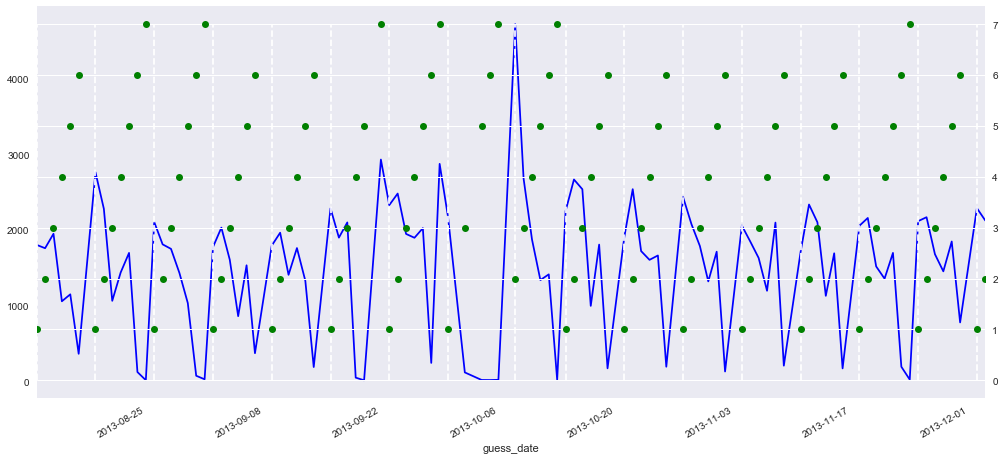

In [20]:
# 以真实日期为横轴坐标做图
drawDf = dataDf.loc[200:300]
fig, ax = plt.subplots(figsize=(17,8))
drawDf.set_index('guess_date', inplace=True)
drawDf['cnt'].plot(ax=ax, style='b-')
drawDf['day_of_week'].plot(ax=ax, style='go', secondary_y=True)
plt.vlines(x=drawDf[drawDf.new_week].index,ymin=0,ymax=7,colors='w',linestyles='dashed')